In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.random as jr
import tensorflow_probability as tfp
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)

gpu


2025-01-05 22:20:45.690354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 22:20:45.690390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 22:20:45.691483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 22:20:52.098477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pwd

'/home/makinen/repositories/des-hybrid'

In [3]:
cd wl-sbi/automate_run

/home/makinen/repositories/des-hybrid/wl-sbi/automate_run


/home/makinen/venvs/des/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# des tfrecords loader code

In [4]:
foos = ["1_1", "3_4"]

if "_" in foos[0]:
    print('yeet')

yeet


In [7]:
import glob
import os
import re

import tensorflow as tf
import tensorflow_datasets as tfds


base_path = "/data103/makinen/des_sims/Gower_street_SBI_tfrecords/"
patch = "A"
use_noise_realisations =['0','1','2','3','10', '11']#,'11','12','13','14','15']



def gaussian_noise_augmentation(x, y, cls):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-7,
                        dtype = tf.float32
                        ) #Mask option?
    return x,y, cls

def gaussian_noise_augmentation(x, y, cls):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-5,
                        dtype = tf.float32
                        ) #Mask option?

    # data is now a dictionary
    
    return {"y": {"kappa": x, "cls": cls}, "theta": y}

# def gaussian_noise_augmentation(dataA, dataB):

#     #dataA,dataB = poop

#     x_A, y, cls = dataA
#     x_A += tf.random.normal(
#                         shape = [512, 512,8],
#                         mean = 0,
#                         stddev = 1e-3,
#                         dtype = tf.float32
#                         ) #Mask option?

#     x_B, _, _ = dataB
#     x_B += tf.random.normal(
#                         shape = [512, 512,8],
#                         mean = 0,
#                         stddev = 1e-3,
#                         dtype = tf.float32
#                         ) #Mask option?
    
    

#     # data is now a dictionary
    
#     return {"y": {"kappa_A": x_A, "kappa_B": x_B, "cls": cls}, "theta": y}


def ret_scaled_param(data,param):
    s = 0.6
    if param == 'AIA':
        hi = 3
        lo = -3

    if param == "s8":
        hi = 1.32
        lo = 0.4

    if param == 'om':
        hi = 0.5
        lo = 0.13

    if param == "h":
        hi = 0.6
        lo = 0.8

    if param == 'w':
        hi = -0.33
        lo = -1.8
    if param == "ns":
        hi = 0.99
        lo = 0.94
    if param == 'ob':
        hi = 0.061
        lo = 0.037


    return (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5

def param_proc(data, scale_params=True):
    Y = []
    for p in sel_params:
        # scale params if so desired
        if scale_params:
            if p=="S8":
                Y.append(data["s8"]*tf.math.sqrt(data["om"]/0.3)-0.25)
            else:
                Y.append(ret_scaled_param(data, p))
                
        # else just return the param
        else:
            Y.append(data[p])
            
    Y = tf.convert_to_tensor( Y , dtype = tf.float32)
    return Y

def cls_proc(data):
    Cls = []
    for c in cl_modes:

        cls = tf.io.parse_tensor(data[c], out_type=tf.float32)
        cls = tf.cast(cls, tf.float32)
        
        Cls.append(cls)
    
    return Cls #tf.convert_to_tensor(Cls, dtype=tf.float32)

def return_train_test_lists(patch):
    files = glob.glob(base_path + "{}/".format(patch) +"shear_maps_*")
    print(base_path + "{}/".format(patch) +"shear_maps_*")

    # sort the files to match A to B to C !
    files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])

    
    print(len(files))
    train_file_list = []
    test_file_list = []
    lfi_file_list = []
    for file in files:
        noiserel = file.split("_rel")[0].split('noiserel')[-1]
        if noiserel in use_noise_realisations:
            if noiserel == '3':
                test_file_list.append(file)
            elif noiserel == '10':
                lfi_file_list.append(file)
            else:
                train_file_list.append(file)
    return train_file_list, test_file_list, lfi_file_list

def parse_serialized_file(cereal_yum, scale_params=True):

    features = {
            "kappa_patch":  tf.io.FixedLenFeature([], tf.string),
            #"CLS":  tf.io.FixedLenFeature([], tf.float32, default_value=0.0),

            # load the cls values
            "1_1": tf.io.FixedLenFeature([], tf.string),
            "1_2": tf.io.FixedLenFeature([], tf.string),
            "1_3": tf.io.FixedLenFeature([], tf.string),
            "1_4": tf.io.FixedLenFeature([], tf.string),
            "2_2": tf.io.FixedLenFeature([], tf.string),
            "2_3": tf.io.FixedLenFeature([], tf.string),
            "2_4": tf.io.FixedLenFeature([], tf.string),
            "3_3": tf.io.FixedLenFeature([], tf.string),
            "3_4": tf.io.FixedLenFeature([], tf.string),
            "4_4": tf.io.FixedLenFeature([], tf.string),

            # load parameters
            "s8": tf.io.FixedLenFeature([], tf.float32),
            "om": tf.io.FixedLenFeature([], tf.float32),
            "AIA": tf.io.FixedLenFeature([], tf.float32),
            "w": tf.io.FixedLenFeature([], tf.float32)
    }

    data = tf.io.parse_single_example(cereal_yum, features)

    print("cereal yum", cereal_yum)

    #print("data cls", data["CLS"].shape)

    X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    X_DS = tf.cast(X_DS, tf.float32)
    X_DS = tf.reshape(X_DS, shape=(8,512,512))
    X_DS = tf.transpose(X_DS, perm = [1,2,0])

    #X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    #X_DS = tf.cast(X_DS, tf.float32)
    
    # process params and Cls
    Y = param_proc(data, scale_params=scale_params)
    CLS_DS = cls_proc(data)
    
    #Shapes?
    return X_DS,Y,CLS_DS



In [8]:

with tf.device("CPU"):
    sel_params = ["om","s8","w"]
    cl_modes = ["1_1","1_2","1_3","1_4","2_2","2_3","2_4","3_3","3_4", "4_4"]
    BATCH_SIZE = 64
    EPOCHS = 1000 # max epochs
    n_readers=1
    try:
        del train_dataset
        del test_dataset
        gc.collect()
    except:
        pass        

    SHUFFLE_BUFFER_SIZE = 100
    train_files, test_files, lfi_files = return_train_test_lists('{}'.format("A"))
    train_files_B, test_files_B, lfi_files_B = return_train_test_lists('{}'.format("B"))

    # check to see if files are mismatched
    for i,t in enumerate(train_files):
        if t[55:] == train_files_B[i][55:]:
            pass
        else:
            print("alert ! file mismatch")

    # check to see if we're matching

    num_train_files = len(train_files)
    num_test_files = len(test_files)
    num_lfi_files = len(lfi_files)
    print("train files: ", num_train_files, "test files: ", num_test_files, "lfi files: ", num_lfi_files)

    train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
    train_datasetB = tf.data.Dataset.from_tensor_slices(train_files_B)

    # concat
    #train_dataset = tf.data.Dataset.zip((train_dataset,train_datasetB))

    
    train_dataset = train_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )


    train_datasetB = train_datasetB.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # # parse, output signature (kg, sn, cosmo, index)
    train_dataset = train_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    train_datasetB = train_datasetB.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )



    # train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    train_dataset = train_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)
    train_datasetB = train_datasetB.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)

    # stack A and B patches
    train_dataset = tf.data.Dataset.zip((train_dataset,train_datasetB))

    def consolidate_dsets(A,B):
        # check that cosmo params are the same        
        return {"y": {"kappa_A": A["y"]["kappa"], "kappa_B": B["y"]["kappa"],
                          "cls": A["y"]["cls"]}, "theta": A["theta"], "theta_A": A["theta"], "theta_B":B["theta"]}
    
    train_dataset = train_dataset.map(lambda A,B: consolidate_dsets(A,B))

    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


    # TEST DATASET
    test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
    test_datasetB = tf.data.Dataset.from_tensor_slices(test_files_B)
    
    test_dataset = test_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    test_datasetB = test_datasetB.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # # parse, output signature (kg, sn, cosmo, index)
    test_dataset = test_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    test_datasetB = test_datasetB.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    test_dataset = test_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)
    test_datasetB = test_datasetB.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)

    # stack patch datasets
    test_dataset = tf.data.Dataset.zip((test_dataset,test_datasetB))

    # consolidate patch A and B
    test_dataset = test_dataset.map(lambda A,B: consolidate_dsets(A,B))


    # test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    
    # SET DATASETS AS NUMPY ITERATORS
    train_dataset = train_dataset.repeat(EPOCHS).as_numpy_iterator()
    test_dataset = test_dataset.repeat(EPOCHS).as_numpy_iterator()

    train_dataset.num_samples = (num_train_files // BATCH_SIZE) * BATCH_SIZE
    train_dataset.num_batch_per_epoch = num_train_files // BATCH_SIZE
    
    test_dataset.num_samples = (num_test_files // BATCH_SIZE) * BATCH_SIZE
    test_dataset.num_batch_per_epoch = num_test_files // BATCH_SIZE
    
    # FINALLY DO THE LFI DATASET
         
    lfi_dataset = tf.data.Dataset.from_tensor_slices(lfi_files)
    lfi_datasetB = tf.data.Dataset.from_tensor_slices(lfi_files_B)

    lfi_dataset = lfi_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    lfi_datasetB = lfi_datasetB.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # parse, output signature (kg, sn, cosmo, index)
    lfi_dataset = lfi_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example,
            scale_params=False
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    lfi_datasetB = lfi_datasetB.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example,
            scale_params=False
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    
    lfi_dataset = lfi_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)
    lfi_datasetB = lfi_datasetB.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)

    lfi_dataset = tf.data.Dataset.zip((lfi_dataset,lfi_datasetB))
    lfi_dataset = lfi_dataset.map(lambda A,B: consolidate_dsets(A,B))


    lfi_dataset = lfi_dataset.batch(BATCH_SIZE, drop_remainder=False)
    lfi_dataset = lfi_dataset.as_numpy_iterator()
    lfi_dataset.num_batch_per_epoch = num_lfi_files // BATCH_SIZE




/data103/makinen/des_sims/Gower_street_SBI_tfrecords/A/shear_maps_*
30880
/data103/makinen/des_sims/Gower_street_SBI_tfrecords/B/shear_maps_*
30880
train files:  12352 test files:  3088 lfi files:  3088
cereal yum Tensor("args_0:0", shape=(), dtype=string)
cereal yum Tensor("args_0:0", shape=(), dtype=string)
cereal yum Tensor("args_0:0", shape=(), dtype=string)
cereal yum Tensor("args_0:0", shape=(), dtype=string)
cereal yum Tensor("args_0:0", shape=(), dtype=string)
cereal yum Tensor("args_0:0", shape=(), dtype=string)


In [9]:
train_dataset.num_samples, train_dataset.num_batch_per_epoch, 

(12352, 193)

(64, 512, 512, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 512, 512, 8) [0.45952517 0.43853354 0.522881  ] (64, 10, 2, 4, 28)


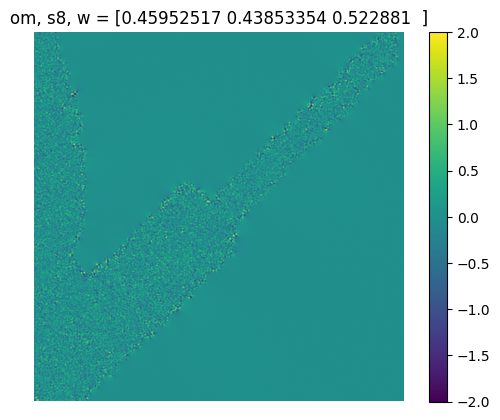

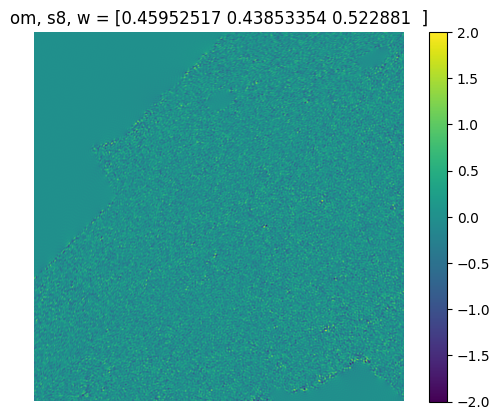

/tmp/ipykernel_288161/3240172165.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


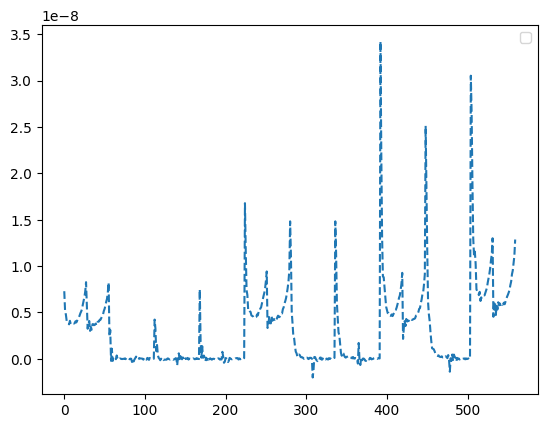

/tmp/ipykernel_288161/3240172165.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


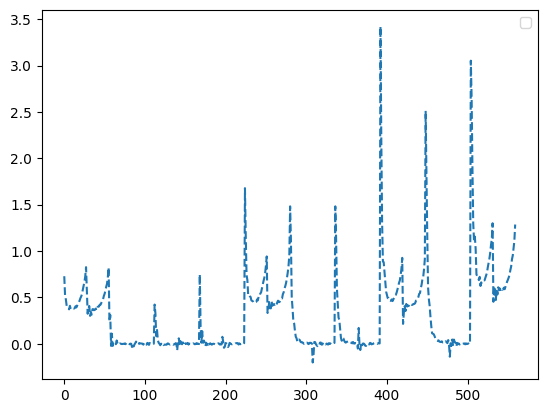

2025-01-05 22:21:44.619560: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


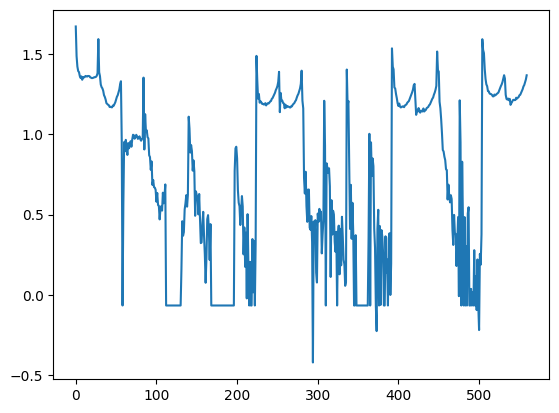

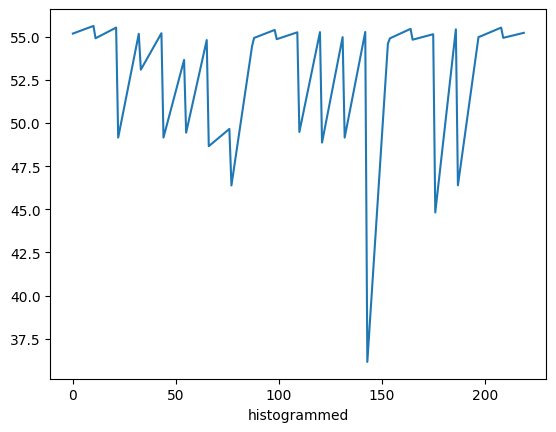

(64, 512, 512, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 512, 512, 8) [0.6404208  0.32364213 0.5542743 ] (64, 10, 2, 4, 28)


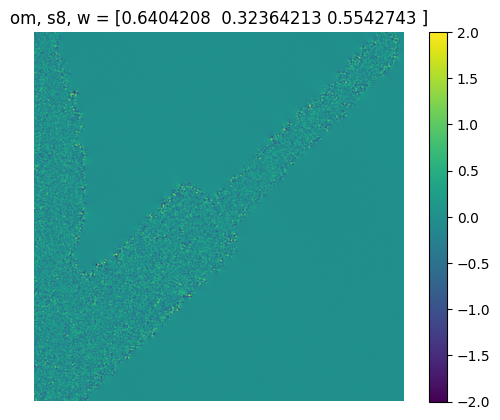

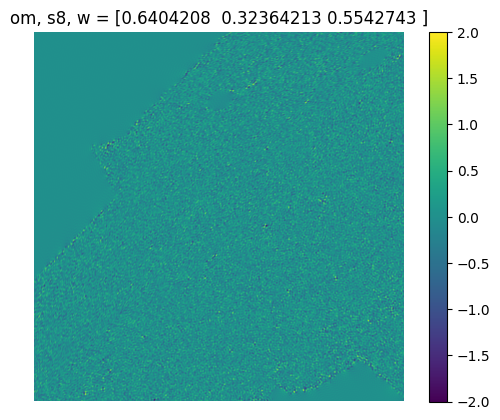

/tmp/ipykernel_288161/3240172165.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


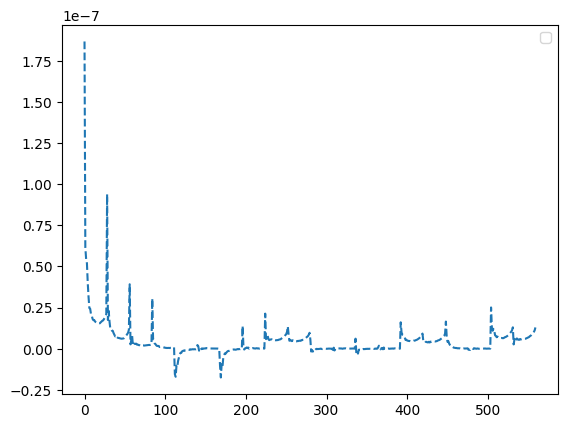

/tmp/ipykernel_288161/3240172165.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


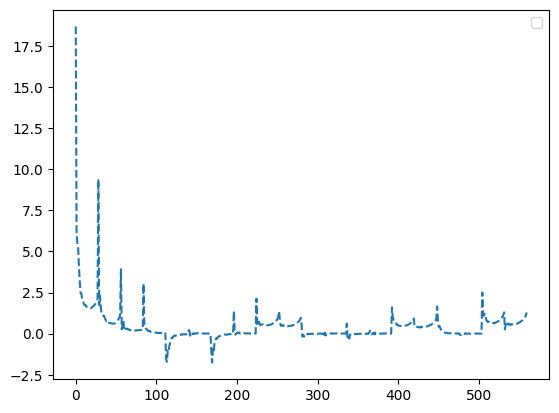

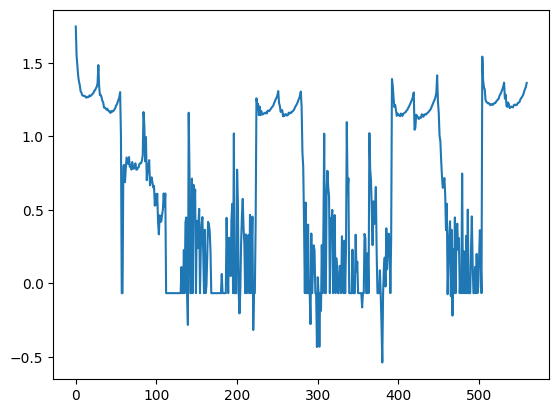

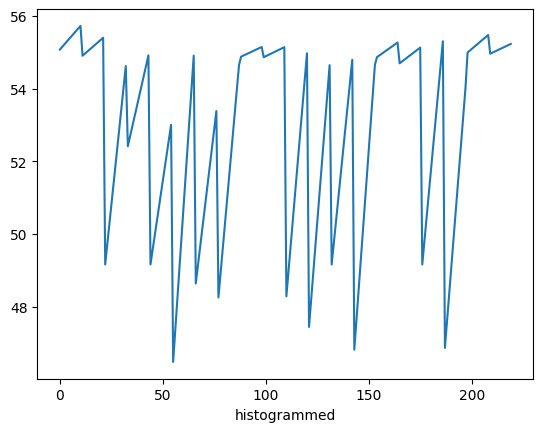

In [10]:
import jax

for i in range(2):
    data = next(iter(test_dataset))

    #data = next(train_dataset)

    x = data["y"]["kappa_B"]
    print(x.shape)
    y = data["theta"]
    cls = data["y"]["cls"]
    #x, y = x.numpy(), y.numpy().tolist()
    print(type(x), type(cls))

    print(x.shape, y[0], cls.shape)

    #print(cls)
    
    
    #ax = plt.subplot(4, 4, i + 1)
    plt.imshow((x[0, :, :, 7]) * 10, vmin=-2, vmax=2)
    plt.colorbar()
    plt.axis("off")
    #name = config.labels[y]
    plt.title("om, s8, w = " + str(y[0]), fontsize=12)
    plt.show()

    x = data["y"]["kappa_A"]
    plt.imshow((x[0, :, :, 7]) * 10, vmin=-2, vmax=2)
    plt.colorbar()
    plt.axis("off")
    #name = config.labels[y]
    plt.title("om, s8, w = " + str(y[0]), fontsize=12)
    plt.show()


    #plt.plot((cls[2, :, 0, 0, :]).reshape(-1,2,14,2).mean(-1).reshape(-1), label='dim 0') # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot((cls[2, :, 1, 0, :]).reshape(-1,2,14,2).mean(-1).reshape(-1), ls='--', label='dim 1')


    plt.plot((cls[2, :, 0, 0::3, :]).reshape(-1), ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, mock/rand, E/B ?, k-bin)
    plt.legend()
    plt.show()


    plt.plot((cls[2, :, 0, 0::3, :] * 1e8).reshape(-1), ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, mock/rand, E/B ?, k-bin)
    plt.legend()
    plt.show()

    cls = jnp.where(cls.reshape(-1) < 0, 1e-11, cls.reshape(-1)).reshape(cls.shape)

    # let's use this log-transformation
    plt.plot(np.concatenate(((jnp.log((cls)**2) + 50.) / 10.)[5, :, 0, 0::3, :], 0).reshape(-1)) # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot(np.concatenate(((jnp.log((cls)**2) + 50.) / 10.)[5, :, 1, 0::3, :], 0).reshape(-1))
    plt.show()
    
    _histfn = lambda d: jnp.histogram(jnp.log(d**2) +50. , bins=10)[1]
    _histfn = jax.vmap(_histfn)
    #hists = jax.vmap(_histfn)((((jnp.log((cls)**2) + 50.) / 10.)[5, :, 0, 0::3, :])).reshape(-1)
    hists = jax.vmap(_histfn)(((jnp.log(cls**2) + 50.)[5, :, 0, 0::3, :])).reshape(-1)

    plt.plot(hists)
    plt.xlabel("histogrammed")

    #cls = jnp.where(cls.reshape(-1) < 0, 0, (jnp.log(cls.reshape(-1)))).reshape(cls.shape)

    #plt.plot((cls[2, :, 0, 0, :]).reshape(-1) , ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot((cls[2, :, 1, 0, :]).reshape(-1) , ls='--')

    

    plt.show()

# jax dataloader code

In [6]:
import jax.tree_util
import tensorflow as tf
from jax import Array
from jax import numpy as jnp
from jax import random as jr
from jax._src.flatten_util import ravel_pytree
from typing import Callable

from sbijax._src.util.types import PyTree


# pylint: disable=missing-class-docstring,too-few-public-methods
class DataLoader:
    # noqa: D101
    def __init__(self, itr, num_samples):  # noqa: D107
        self._itr = itr
        self.num_samples = num_samples

    def __iter__(self):
        """Iterate over the data set."""
        yield from self._itr.as_numpy_iterator()


# pylint: disable=missing-function-docstring
def as_batch_iterators(
    rng_key: Array, data: PyTree, batch_size, split, shuffle,
    noise_simulator: Callable = None
):
    """Create two data batch iterators from a data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        batch_size: size of each batch
        split: fraction of data to use for training data set. Rest is used
            for validation data set.
        shuffle: shuffle the data set or no
        noise_simulator: noise simulator with signature f(key, sim)

    Returns:
        returns two iterators
    """
    n = data["y"].shape[0]
    n_train = int(n * split)

    if shuffle:
        idxs = jr.permutation(rng_key, jnp.arange(n))
        data = jax.tree_util.tree_map(lambda x: x[idxs], data)

    y_train = jax.tree_util.tree_map(lambda x: x[:n_train], data)
    y_val = jax.tree_util.tree_map(lambda x: x[n_train:], data)

    train_rng_key, val_rng_key = jr.split(rng_key)




    train_itr = as_batch_iterator(train_rng_key, y_train, batch_size, shuffle, noise_simulator)
    val_itr = as_batch_iterator(val_rng_key, y_val, batch_size, shuffle, noise_simulator)

    return train_itr, val_itr


# THIS FUNCTION JUST SHUFFLES THE DATASET
def as_batched_numpy_iterator_from_tf(
    rng_key: Array, data: tf.data.Dataset, iter_size, batch_size, shuffle
):
    """Create a data batch iterator from a tensorflow data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        iter_size: total number of elements in the data set
        batch_size: size of each batch
        shuffle: shuffle the data set or no

    Returns:
        a tensorflow iterator
    """
    # hack, cause the tf stuff doesn't support jax keys :)
    max_int32 = jnp.iinfo(jnp.int32).max
    seed = jr.randint(rng_key, shape=(), minval=0, maxval=max_int32)

    data = (
        data.shuffle(
            10 * batch_size,
            seed=int(seed),
            reshuffle_each_iteration=shuffle,
        )
        .batch(batch_size)
        .prefetch(buffer_size=batch_size)
    )
    return DataLoader(data, iter_size)


# pylint: disable=missing-function-docstring
def as_batch_iterator(rng_key: Array, data: PyTree, batch_size, shuffle,
                      noise_simulator: Callable = None
                      ):
    """Create a data batch iterator from a data set.

    Args:
        rng_key: a jax random key
        data: a named tuple with elements 'y' and 'theta' all data
        batch_size: size of each batch
        shuffle: shuffle the data set or no
        noise_simulator: add noise on top of simulation
    Returns:
        a tensorflow iterator
    """
    y = data["y"]

    if noise_simulator is not None:
        key, rng_key = jr.split(rng_key)
        keys = jr.split(key, num=y.shape[0])
        y = jax.vmap(noise_simulator)(keys, y)

    data = {
        "y": y,
        "theta": jax.vmap(lambda x: ravel_pytree(x)[0])(data["theta"]),
    }
    itr = tf.data.Dataset.from_tensor_slices(data)
    return as_batched_numpy_iterator_from_tf(
        rng_key, itr, data["y"].shape[0], batch_size, shuffle
    )


def as_numpy_iterator_from_slices(data: PyTree, batch_size):
    itr = tf.data.Dataset.from_tensor_slices(data)
    itr = itr.batch(batch_size).prefetch(buffer_size=batch_size)
    itr = itr.as_numpy_iterator()
    return itr





In [10]:
train_dataset.num_batch_per_epoch, lfi_dataset.num_batch_per_epoch

(193, 48)

## adapt the mdn code from `sbijax` into flax

In [11]:
from functools import partial

import jax
import numpy as np
import optax
from absl import logging
from jax import numpy as jnp
from jax import random as jr
from jax import scipy as jsp
from jax._src.flatten_util import ravel_pytree
from tqdm import tqdm

from sbijax._src._ne_base import NE
from sbijax._src.util.data import as_inference_data
from sbijax._src.util.early_stopping import EarlyStopping
#from sbijax._src.util.dataloader import as_batch_iterators



# custom dataloader class to support additive noise (or simulator)


# ruff: noqa: PLR0913, E501
class myNPE(NE):
    """Neural posterior estimation.

    Implements the method introduced in :cite:t:`greenberg2019automatic`.
    In the literature, the method is usually referred to as APT or NPE-C, but
    here we refer to it simply as NPE.

    Args:
        model_fns: a tuple of calalbles. The first element needs to be a
            function that constructs a tfd.JointDistributionNamed, the second
            element is a simulator function.
        density_estimator: a (neural) conditional density estimator
            to model the posterior distribution
        num_atoms: number of atomic atoms

    Examples:
        >>> from sbijax import NPE
        >>> from sbijax.nn import make_maf
        >>> from tensorflow_probability.substrates.jax import distributions as tfd
        ...
        >>> prior = lambda: tfd.JointDistributionNamed(
        ...     dict(theta=tfd.Normal(0.0, 1.0))
        ... )
        >>> s = lambda seed, theta: tfd.Normal(theta["theta"], 1.0).sample(seed=seed)
        >>> fns = prior, s
        >>> neural_network = make_maf(1)
        >>> model = NPE(fns, neural_network)

    References:
        Greenberg, David, et al. "Automatic posterior transformation for likelihood-free inference." International Conference on Machine Learning, 2019.
    """

    def __init__(self, model_fns, density_estimator, num_atoms=10):
        """Construct an SNP object.

        Args:
            model_fns: a tuple of tuples. The first element is a tuple that
                    consists of functions to sample and evaluate the
                    log-probability of a data point. The second element is a
                    simulator function.
            density_estimator: a (neural) conditional density estimator
                to model the posterior distribution
            num_atoms: number of atomic atoms
        """
        super().__init__(model_fns, density_estimator)
        self.num_atoms = num_atoms
        self.n_round = 0

    # ruff: noqa: D417
    def fit(
        self,
        rng_key,
        data,
        *,
        train_dataset=None,
        val_dataset=None,
        noise_simulator=None,
        optimizer=optax.adam(0.0003),
        n_iter=1000,
        batch_size=128,
        percentage_data_as_validation_set=0.1,
        n_early_stopping_patience=10,
        **kwargs,
    ):
        """Fit an SNP model.

        Args:
            rng_key: a jax random key
            data: data set obtained from calling
                `simulate_data_and_possibly_append`
            noise_simulator: noise function with signature `data_noise = fn(key, data)`
            optimizer: an optax optimizer object
            n_iter: maximal number of training iterations per round
            batch_size:  batch size used for training the model
            percentage_data_as_validation_set: percentage of the simulated
                data that is used for validation and early stopping
            n_early_stopping_patience: number of iterations of no improvement
                of training the flow before stopping optimisation


        Returns:
            a tuple of parameters and a tuple of the training information
        """
        itr_key, rng_key = jr.split(rng_key)

        
        if train_dataset is None:
            train_iter, val_iter = self.as_iterators(
                itr_key, data, batch_size, percentage_data_as_validation_set,
                noise_simulator
            )
        else:
            train_iter = train_dataset
            val_iter = val_dataset
        
        params, losses = self._fit_model_single_round(
            seed=rng_key,
            train_iter=train_iter,
            val_iter=val_iter,
            optimizer=optimizer,
            n_iter=n_iter,
            n_early_stopping_patience=n_early_stopping_patience,
            n_atoms=self.num_atoms,
        )

        return params, losses

    # pylint: disable=undefined-loop-variable
    def _fit_model_single_round(
        self,
        seed,
        train_iter,
        val_iter,
        optimizer,
        n_iter,
        n_early_stopping_patience,
        n_atoms,
    ):
        init_key, seed = jr.split(seed)
        params = self._init_params(init_key, **next(iter(train_iter)))
        state = optimizer.init(params)

        n_round = self.n_round
        if n_round == 0:

            def loss_fn(params, rng, **batch):
                # upack tuple
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=jnp.array(batch["theta"]),
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(params, rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params,
                    rng,
                    n_atoms,
                    theta=jnp.array(batch["theta"]),
                    y=jnp.array(batch["y"]),
                )
                return -jnp.mean(lp)

        @jax.jit
        def step(params, rng, state, **batch):
            loss, grads = jax.value_and_grad(loss_fn)(params, rng, **batch)
            updates, new_state = optimizer.update(grads, state, params)
            new_params = optax.apply_updates(params, updates)
            return loss, new_params, new_state

        losses = np.zeros([n_iter, 2])
        early_stop = EarlyStopping(1e-3, n_early_stopping_patience)
        best_params, best_loss = None, np.inf
        logging.info("training model")

        pbar = tqdm(range(n_iter), leave=True, position=0) # progress bar
        for i in pbar:
            train_loss = 0.0
            rng_key = jr.fold_in(seed, i)
            for b in range(train_iter.num_batch_per_epoch):

                batch = next(iter(train_iter))
                train_key, rng_key = jr.split(rng_key)
                batch_loss, params, state = step(
                    params, train_key, state, **batch
                )
                #print("batch_loss", batch_loss)
                train_loss += batch_loss * (
                    jax.tree.leaves(batch["y"])[0].shape[0] / train_iter.num_samples
                )
                #print("train_loss", train_loss)
            
            val_key, rng_key = jr.split(rng_key)
            validation_loss = self._validation_loss(
                val_key, params, val_iter, n_atoms
            )
            #print("validation_loss", validation_loss)
            
            losses[i] = jnp.array([train_loss, validation_loss])
            pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(i, train_loss, validation_loss))
            
            _, early_stop = early_stop.update(validation_loss)
            if early_stop.should_stop:
                logging.info("early stopping criterion found")
                break
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_params = params.copy()

        self.n_round += 1
        losses = jnp.vstack(losses)[: (i + 1), :]
        return best_params, losses

    def _init_params(self, rng_key, **init_data):
        params = self.model.init(
            rng_key, method="log_prob", y=jnp.array(init_data["theta"]), x=init_data["y"]
        )
        return params

    def _proposal_posterior_log_prob(self, params, rng, n_atoms, theta, y):
        n = theta.shape[0]
        n_atoms = np.maximum(2, np.minimum(n_atoms, n))
        repeated_y = jnp.repeat(y, n_atoms, axis=0)
        probs = jnp.ones((n, n)) * (1 - jnp.eye(n)) / (n - 1)

        choice = partial(
            jr.choice, a=jnp.arange(n), replace=False, shape=(n_atoms - 1,)
        )
        sample_keys = jr.split(rng, probs.shape[0])
        choices = jax.vmap(lambda key, prob: choice(key, p=prob))(
            sample_keys, probs
        )
        contrasting_theta = theta[choices]

        atomic_theta = jnp.concatenate(
            (theta[:, None, :], contrasting_theta), axis=1
        )
        atomic_theta = atomic_theta.reshape(n * n_atoms, -1)

        log_prob_posterior = self.model.apply(
            params, None, method="log_prob", y=atomic_theta, x=repeated_y
        )
        log_prob_posterior = log_prob_posterior.reshape(n, n_atoms)
        log_prob_prior = self.prior_log_density_fn(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(n, n_atoms)

        unnormalized_log_prob = log_prob_posterior - log_prob_prior
        log_prob_proposal_posterior = unnormalized_log_prob[
            :, 0
        ] - jsp.special.logsumexp(unnormalized_log_prob, axis=-1)

        return log_prob_proposal_posterior

    def _validation_loss(self, rng_key, params, val_iter, n_atoms):
        if self.n_round == 0:

            def loss_fn(rng, **batch):
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=jnp.array(batch["theta"]),
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params, rng, n_atoms, jnp.array(batch["theta"]), batch["y"]
                )
                return -jnp.mean(lp)

        def body_fn(batch, rng_key):
            loss = jax.jit(loss_fn)(rng_key, **batch)
            return loss * (jax.tree.leaves(batch["y"])[0].shape[0] / val_iter.num_samples)

        loss = 0.0
        for b in range(val_iter.num_batch_per_epoch):
            batch = next(iter(val_iter))
            val_key, rng_key = jr.split(rng_key)
            loss += body_fn(batch, val_key)
        return loss

    @staticmethod
    def as_iterators(
        rng_key, data, batch_size, percentage_data_as_validation_set,
        noise_simulator
    ):
        """Convert the data set to an iterable for training.

        Args:
            rng_key: a jax random key
            data: a tuple with 'y' and 'theta' elements
            batch_size: the size of each batch
            percentage_data_as_validation_set: fraction

        Returns:
            two batch iterators
        """
        print("hooray")
        return as_batch_iterators(
            rng_key,
            data,
            batch_size,
            1.0 - percentage_data_as_validation_set,
            True,
            noise_simulator
        )

    def sample_posterior(
        self, rng_key, params, observable, *, n_samples=4_000, **kwargs
    ):
        r"""Sample from the approximate posterior.

        Args:
            rng_key: a jax random key
            params: a pytree of neural network parameters
            observable: observation to condition on
            n_samples: number of samples to draw

        Returns:
            returns an array of samples from the posterior distribution of
            dimension (n_samples \times p)
        """
        observable = jnp.atleast_2d(observable)

        thetas = None
        n_curr = n_samples
        n_total_simulations_round = 0
        _, unravel_fn = ravel_pytree(self.prior_sampler_fn(seed=jr.PRNGKey(1)))
        while n_curr > 0:
            n_sim = jnp.minimum(200, jnp.maximum(200, n_curr))
            n_total_simulations_round += n_sim
            sample_key, rng_key = jr.split(rng_key)
            proposal = self.model.apply(
                params,
                sample_key,
                method="sample",
                sample_shape=(n_sim,),
                x=jnp.tile(observable, [n_sim, 1]),
            )
            proposal_probs = self.prior_log_density_fn(
                jax.vmap(unravel_fn)(proposal)
            )
            proposal_accepted = proposal[jnp.isfinite(proposal_probs)]
            if thetas is None:
                thetas = proposal_accepted
            else:
                thetas = jnp.vstack([thetas, proposal_accepted])
            n_curr -= proposal_accepted.shape[0]
        self.n_total_simulations += n_total_simulations_round

        ess = float(thetas.shape[0] / n_total_simulations_round)
        thetas = jax.tree_map(
            lambda x: x.reshape(1, *x.shape),
            jax.vmap(unravel_fn)(thetas[:n_samples]),
        )
        inference_data = as_inference_data(thetas, jnp.squeeze(observable))
        return inference_data, ess

In [12]:
from collections.abc import Iterable
from typing import Callable, Sequence

import haiku as hk
import haiku.experimental.flax as hkflax
import flax.linen as nn
import jax
from jax import numpy as jnp
from tensorflow_probability.substrates.jax import distributions as tfd



# pylint: disable=too-many-arguments
def my_make_mdn(
    n_dimension: int,
    n_components: int,
    hidden_sizes: Iterable[int] = (64, 64),
    activation: Callable = jax.nn.relu,
    embedding_net: nn.Module = None
):
    """Create an affine masked autoregressive flow.

    The MAFs use `n_layers` layers and are parameterized using MADE networks
    with `hidden_sizes` neurons per layer.

    Args:
        n_dimension: dimensionality of theta
        n_components: number of mixture components
        hidden_sizes: sizes of hidden layers for each normalizing flow. E.g.,
            when the hidden sizes are a tuple (64, 64), then each maf layer
            uses a MADE with two layers of size 64 each
        activation: a jax activation function

    Returns:
        a normalizing flow model
    """

    @hk.transform
    def mdn(method, **kwargs):

        #n = kwargs["x"].shape[0]
        #x = jnp.array(kwargs["x"])
        n = jax.tree.leaves(kwargs["x"])[0].shape[0] # all elements of data dict should be batched
        x = kwargs["x"]

        #print("x mdn input", x.shape)

        # optional embedding network
        if embedding_net is not None:
          mod = hkflax.lift(embedding_net, name='flax_embedding_net')
          # add in a vmap here
          x = jax.vmap(mod)(x)

        xembed = x
        # rest of network
        hidden = hk.nets.MLP(
            hidden_sizes, activation=activation, activate_final=True
        )(x)
        #print("hidden", hidden.shape)
        logits = hk.Linear(n_components)(hidden)
        mu_sigma = hk.Linear(n_components * n_dimension * 2)(hidden)
        mu, sigma = jnp.split(mu_sigma, 2, axis=-1)

        mixture = tfd.MixtureSameFamily(
            tfd.Categorical(logits=logits),
            tfd.MultivariateNormalDiag(
                mu.reshape(n, n_components, n_dimension),
                jnp.exp(sigma.reshape(n, n_components, n_dimension)),
            ),
        )
        if method == "sample":
            return mixture.sample(seed=hk.next_rng_key())
        elif method == "embedding":
            # could also return logits, mu_sigma
            return xembed
        else:
            return mixture.log_prob(kwargs["y"])

    return mdn



In [13]:
pwd

'/home/makinen/repositories/des-hybrid/wl-sbi/automate_run'

In [14]:
#@title config code
import sys,os
import yaml
import jax_cosmo as jc

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import sys,os
import yaml

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


# -----
# folder to load config file
CONFIG_PATH = "./config"

config_name = "config_N128.yaml"
noiseamp = 0.125

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config(config_name)
# -----


# -----
# UNPACK GLOBAL CONFIG VALUES
outdir = config["datadir"]
N = 512 #config["N"]
L = 1024 #config["L"]
num_tomo = config["num_tomo"]

indices = jnp.array(indices_vector(config["num_tomo"]))
cl_shape = config["cls_outbins"] * len(indices)


num_bins = config["cls_outbins"]
chi_grid = (jnp.arange(config["Nz"]) + 0.5) * config["Lz"] / float(config["Nz"])
cl_cut = config["cl_cut"]
chi_source = chi_grid[-1]

# cls function to pass to network
def cls_allbins_nonoise(tomo_data, chunk_size=2):
    def get_spec_nonoise(index, tomo_data):
        ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, config["L"])
        return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=num_bins)[0]
    gps = partial(get_spec_nonoise, tomo_data=tomo_data)

    return jax.vmap(gps)(indices) #nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)

# define the mpk layer before initialising network

dtype = jnp.bfloat16
kernel_size = config["mpk_kernel"]
polynomial_degrees = config["polynomial_degrees"]
do_moped = config["do_moped"]

mpk_layer = MultipoleCNNFactory(
            kernel_shape=(kernel_size, kernel_size),
            polynomial_degrees=polynomial_degrees,
            output_filters=None,
            dtype=dtype)


act = smooth_leaky

key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (num_tomo, N, N)
# -----

# whether or not we're doing moped compression
if do_moped:
    n_t_summaries = config["n_params"]
else:
    n_t_summaries = cl_shape



# noise variance
def compute_variance_catalog(zmean=jnp.array(config["z_means"]), n_gal=config["ngal"]):

    N0 = config["N"]
    N1 = N0
    N2 = config["Nz"]
    L0 = config["L"]
    L1 = L0
    L2 = config["Lz"]

    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence
    rms = 0.3  # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = n_gal / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

#noisevars = compute_variance_catalog()

In [14]:
indices

Array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 3]], dtype=int32)

In [21]:
#@title network code

from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp
import math
from network.NPE import npe
from network.NPE.multipole_cnn import MultipoleConv
from network.NPE.multipole_cnn_factory import MultipoleCNNFactory
import cloudpickle as pickle

Array = Any
import numpy as np

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """

    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad

    # but we want to pad both sides of a given axis, so return a tuple here

    left = deficit // 2
    right = left + (deficit % 2)

    return (left, right)


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = smooth_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2

    @nn.compact
    def __call__(self, x):

        d = self.dim

        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim,
                     strides=(2,)*d if d == 2 else (2,2,1),
                     padding="CIRCULAR")(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x2 = self.act(x2 + z)


        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                     strides=(3,)*d if d == 2 else (3,3,1),
                     padding="CIRCULAR")(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                         strides=(4,)*d if d == 2 else (4,4,1),
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x4 = self.act(x4 + z)


        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)

        x3 = jnp.pad(x3,
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)),
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x2)
        x2 = self.act(x2)


        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2


# histogram function for the Cls
_histfn = lambda d: jnp.histogram(jnp.arange(28), weights=(jnp.log(d**2) + 50.)/200., bins=4)[0]
_histfn = jax.vmap(jax.vmap(_histfn))


class MPK_InceptNet_A(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    multipole_tomo1: MPK_layer
    cl_compression: Callable
    div_factor: float = 0.02
    cl_shape: int = 60
    n_outs: int = 10
    n_extra: int = 2
    act: Callable = smooth_leaky
    dtype: Any = jnp.bfloat16
    do_cls: bool = True

    @nn.compact
    def __call__(self, x, return_embed=False):

        # unpack data
        # cls summaries -> E-mode for now

        cls_summs = x["cls"][:, 0, 0::3, :]   # (10, 2, 4, 28) = (tomo, E/B, ?, ell)
        cls_summs = _histfn(cls_summs).reshape(-1) 
        
        x = x["kappa_A"]
        
        # first just take first four filters (E modes !)
        x = x[..., :]

        #print("x input", x.shape)
        
        filters = self.filters

        #print("x", type(x))

        # optionally do the moped compression

        xlog = log_transform(jax.lax.stop_gradient(x)) / 0.02 
        x = xlog + 1.0


        #x /= 0.4
        x = x.astype(self.dtype)
        # embed the data in multipoles
        x = self.multipole_tomo1(x) # 512x512

        xembed = x

        # incept net out
        x_1_256, x_1_128 = InceptStride(filters=filters, pad_shape=512, act=self.act, do_1x1=False)(x)

        x_2_128, x_1_64 = InceptStride(filters=filters, pad_shape=256, act=self.act, do_1x1=False)(x_1_256)
        
        # now concatenate the remaining 128x128 arrays
        x_2_128 = jnp.concatenate([x_1_128, x_2_128], -1)
        filters = [f*2 for f in filters]
        x_2_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x_2_128)

        # concatenate 64x64
        x_2_64 = jnp.concatenate([x_1_64, x_2_64], -1)
        filters = [f*2 for f in filters]
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_2_64)
        
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False, do_4x4=False)(x_3_16)
        # concatenate the 8x8s
        x = jnp.concatenate([x_2_8, x_3_8], -1)

        #print("x pre-mean", x.shape)

        # mean pool out
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        # concatenate
        if self.do_cls:
            #cls_summs = nn.Dense(60)(cls_summs)
            x = jnp.concatenate([cls_summs.reshape(-1), x])
        
        # send to last linear combination
        if return_embed:
            return x, xembed.astype(jnp.float32)

        else:
            return x



In [22]:
leaves = jax.tree.leaves(data)
leaves[0].shape

(64, 3)

In [32]:
# initialise mpk model
model_key = jr.PRNGKey(44)
mpk_input_filters = [8,6] # config["mpk_input_filters"]

act = smooth_leaky

patch_A_net = MPK_InceptNet_A(
                    filters=config["filters"],
                    # rest of network
                    multipole_tomo1 = MPK_layer(
                                multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                            strides=config["mpk_strides"],
                                                            pad_size=None) for i,f in enumerate(mpk_input_filters)],
                                act=act),
                    cl_compression=cls_allbins_nonoise,
                    act=act,
                    cl_shape=cl_shape,
                    n_extra=3,
                    dtype=jnp.bfloat16,
                    do_cls=True
)

# initialise wrt to the MDN (rather clunky -- should streamline)


# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


mdn_hidden = (100,100)
n_components = 4 # 2 not so good


modelA = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, 
                                embedding_net=patch_A_net,
                               hidden_sizes=mdn_hidden,
                               activation=jax.nn.swish))


# load weights from last time
w_patch_A = load_obj("/home/makinen/repositories/des-hybrid/w_patchA_05_01_smoothleaky_nolog.pkl")

def apply_embedding(input_data, w=w_patch_A):
    return modelA.model.apply(w, x=input_data, rng=jr.PRNGKey(400), method='embedding')

In [33]:
apply_embedding(data['y']).shape

(64, 83)

## now design a network for patch B

In [34]:
class MPK_InceptNet_B(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    multipole_tomo1: MPK_layer
    existing_compression: Callable
    div_factor: float = 0.02
    n_extra: int = 3
    act: Callable = smooth_leaky
    dtype: Any = jnp.bfloat16
    do_cls: bool = True

    @nn.compact
    def __call__(self, x):

        # unpack data
        # work around the dumb vmap bit
        inputs = {"kappa_A": x["kappa_A"][jnp.newaxis, ...], "cls": x["cls"][jnp.newaxis, ...]}
        existing_info = self.existing_compression(jax.lax.stop_gradient(inputs))
        
        # first just take first four filters (E modes !)
        x = x["kappa_B"]
        x = x[..., :]
        
        filters = self.filters

        xlog = log_transform(jax.lax.stop_gradient(x)) / 0.02 
        x = xlog + 1.0

        x = x.astype(self.dtype)
        # embed the data in multipoles
        x = self.multipole_tomo1(x) # 512x512

        # incept net out
        x_1_256, x_1_128 = InceptStride(filters=filters, pad_shape=512, act=self.act, do_1x1=False)(x)

        x_2_128, x_1_64 = InceptStride(filters=filters, pad_shape=256, act=self.act, do_1x1=False)(x_1_256)
        
        # now concatenate the remaining 128x128 arrays
        x_2_128 = jnp.concatenate([x_1_128, x_2_128], -1)
        filters = [f*2 for f in filters]
        x_2_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x_2_128)

        # concatenate 64x64
        x_2_64 = jnp.concatenate([x_1_64, x_2_64], -1)
        filters = [f*2 for f in filters]
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_2_64)
        
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False, do_4x4=False)(x_3_16)
        # concatenate the 8x8s
        x = jnp.concatenate([x_2_8, x_3_8], -1)
        

        # mean pool out
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        # concatenate
        if self.do_cls:
            #cls_summs = nn.Dense(60)(cls_summs)
            x = jnp.concatenate([existing_info.reshape(-1), x])
        
        return x

In [35]:
act

<PjitFunction of <function smooth_leaky at 0x1515debb2340>>

In [36]:
patch_B_net = MPK_InceptNet_B(
                    filters=config["filters"],
                    # rest of network
                    multipole_tomo1 = MPK_layer(
                                multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                            strides=config["mpk_strides"],
                                                            pad_size=None) for i,f in enumerate(mpk_input_filters)],
                                act=act),
                    existing_compression=apply_embedding,
                    act=act,
                    n_extra=3,
                    dtype=jnp.bfloat16,
                    do_cls=True
)

wembed = patch_B_net.init(model_key, {"kappa_B": jnp.ones((512,512,8)),
                                      "kappa_A": jnp.ones((512,512,8)),
                                      "cls": jnp.ones((10,2,4,28))
                                     }
                                      )


appl = lambda d: patch_B_net.apply(wembed, d)

outs = jax.vmap(appl)(data['y'])

outs.shape

(64, 86)

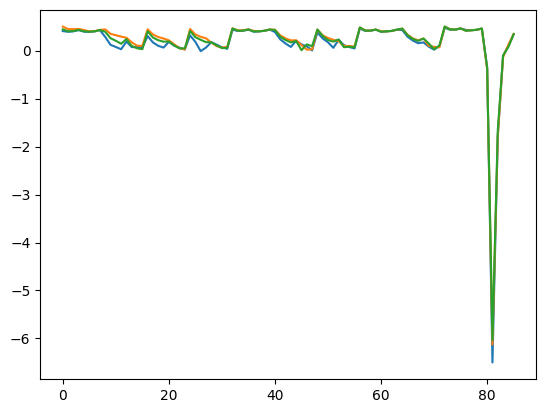

In [37]:

plt.plot((outs[0, :]))
plt.plot((outs[10, :]))
plt.plot((outs[50, :]))
plt.show()

# train network

TODO: make weights an attribute of the network so that we can cut training early

In [ ]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd
import optax

#from network.train_utils import rotate_sim

# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


#mdn_hidden = (70, 70)
mdn_hidden = (100,100)
n_components = 4 # 2 not so good


model = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, 
                               embedding_net=patch_B_net,
                               hidden_sizes=mdn_hidden,
                               activation=jax.nn.swish))



# --- OPTIMISER STUFF
# Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(float(config["gradient_clip"]))]
transf.append(optax.add_decayed_weights(1e-4))
optimizer = optax.chain(
    *transf,
    optax.adam(learning_rate=5e-5)
)
w, losses = model.fit(jr.PRNGKey(2), data=None, 
                      n_iter=64,
                      n_early_stopping_patience=10,  #20
                      train_dataset=train_dataset,
                      val_dataset=test_dataset,
                      noise_simulator=None, 
                      optimizer=optimizer)

epoch 10 loss: -2.91064  val loss: -2.60708:  17%|█▋        | 11/64 [2:04:45<9:38:53, 655.34s/it]

In [48]:
jax.nn.swish

<PjitFunction of <function silu at 0x7f055adca020>>

In [161]:
model.n_round

1

In [63]:
w

{'flax_embedding_net/Dense_0': {'bias': Array([-0.00443047,  0.01617803, -0.00072022], dtype=float32),
  'kernel': Array([[ 0.53439945,  0.35926005, -0.0634074 ],
         [ 0.02247915,  0.20313868,  0.280684  ],
         [-0.43960327, -0.5913128 , -0.2562539 ],
         [ 0.35457212,  0.1941569 , -0.28565156],
         [-0.3128411 , -0.01733779, -0.11893941],
         [ 0.5529517 ,  0.47996274, -0.6033538 ]], dtype=float32)},
 'flax_embedding_net/InceptStride_0/Conv_0': {'bias': Array([0.02021462], dtype=float32),
  'kernel': Array([[[[ 0.28703165],
           [ 0.302299  ],
           [-0.04750075],
           [ 0.12344847],
           [ 0.04423502],
           [-0.10247697]],
  
          [[-0.13758515],
           [ 0.14510262],
           [ 0.26897433],
           [ 0.09738145],
           [ 0.08719975],
           [-0.3106903 ]]],
  
  
         [[[ 0.28012043],
           [ 0.31694755],
           [ 0.34343943],
           [ 0.11028937],
           [ 0.2551182 ],
           [-0.

In [ ]:
# save model weights
save_obj(w, "/home/makinen/repositories/des-hybrid/w_patch_A_B_05_01_smoothleaky")

In [ ]:
np.save("/home/makinen/repositories/des-hybrid/history_patchA_B_05_01_smoothleaky", losses)

In [ ]:
plt.plot(losses)
plt.show()

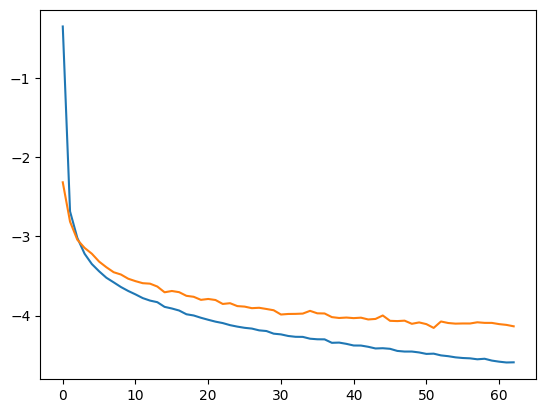

In [52]:
plt.plot(losses)
plt.show()

# load weights

In [20]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd
import optax

#from network.train_utils import rotate_sim

# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


mdn_hidden = (140,140)
n_components = 4 # 2 not so good


model = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, embedding_net=patch_B_net,
                               hidden_sizes=mdn_hidden))


w_trained = load_obj("/home/makinen/repositories/des-hybrid/w_patch_A_B_18_12_swish.pkl")

In [24]:
#w_trained = w

## run through ltu-ili for comprehensive posterior comparison

In [21]:
# define a function to obtain summaries from the embedding module
#appfn = lambda d: model.model.apply(w, x=d, rng=jr.PRNGKey(400), method='embedding')

def apply_embedding(input_data, w=w_trained):
    return model.model.apply(w, x=input_data, rng=jr.PRNGKey(400), method='embedding')

In [22]:
# now apply to the lfi dataset as in Josh's code

summaries_LFI = []
params_Tru_LFI = []

for i,data in tqdm(enumerate(lfi_dataset)):

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_LFI.append(theta_true)
    summaries_LFI.append(summs_out)


summaries_test = []
params_Tru_test = []

for i in tqdm(range(test_dataset.num_batch_per_epoch)):

    data = next(iter(test_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_test.append(theta_true)
    summaries_test.append(summs_out)



49it [02:42,  3.31s/it]
100%|██████████| 48/48 [01:59<00:00,  2.49s/it]


In [174]:
test_dataset.num_batch_per_epoch

48

In [30]:
len(summaries_test)

48

In [23]:
np.concatenate(summaries_LFI, 0).shape

(3088, 88)

In [24]:
summaries_LFI = np.concatenate(summaries_LFI, 0)
params_Tru_LFI = np.concatenate(params_Tru_LFI, 0)

summaries_test = np.concatenate(summaries_test, 0)#[:test_dataset.num_batch_per_epoch]
params_Tru_test = np.concatenate(params_Tru_test, 0)#[:test_dataset.num_batch_per_epoch]


In [42]:
# np.savez("/home/makinen/repositories/des-hybrid/summaries_patchA_04_12_swish",
#          summaries_lfi=summaries_LFI,
#          params_lfi=params_Tru_LFI,
#          summaries_test=summaries_test,
#          params_test=params_Tru_test,
#          )

In [22]:
params_Tru_test

[array([[0.3860099 , 0.5512507 , 0.5752562 ],
        [0.3860099 , 0.5512507 , 0.5752562 ],
        [0.41784152, 0.50311553, 0.5274317 ],
        [0.41784152, 0.50311553, 0.5274317 ],
        [0.41784152, 0.50311553, 0.5274317 ],
        [0.41784152, 0.50311553, 0.5274317 ],
        [0.50122136, 0.54937434, 0.52613163],
        [0.50122136, 0.54937434, 0.52613163],
        [0.50122136, 0.54937434, 0.52613163],
        [0.50122136, 0.54937434, 0.52613163],
        [0.53825766, 0.3472609 , 0.67647725],
        [0.53825766, 0.3472609 , 0.67647725],
        [0.53825766, 0.3472609 , 0.67647725],
        [0.53825766, 0.3472609 , 0.67647725],
        [0.2910592 , 0.38218427, 0.5683849 ],
        [0.2910592 , 0.38218427, 0.5683849 ],
        [0.2910592 , 0.38218427, 0.5683849 ],
        [0.2910592 , 0.38218427, 0.5683849 ],
        [0.38726926, 0.65750355, 0.72314405],
        [0.38726926, 0.65750355, 0.72314405],
        [0.38726926, 0.65750355, 0.72314405],
        [0.38726926, 0.65750355, 0

In [183]:
params_Tru_LFI.shape

(3088, 3)

In [178]:
summaries_LFI[0, :]

array([ 0.5719864 ,  0.46807787,  0.34024888,  0.3989586 ,  0.23041764,
        0.22398224,  0.28264084,  0.24308243,  0.2750496 ,  0.26067123,
        0.25546494,  0.2760086 ,  0.25864717,  0.27627715,  0.265551  ,
        0.2734215 ,  0.28226778,  0.30773926,  0.301754  ,  0.3302605 ,
        0.34467012,  0.36754304,  0.39577028,  0.4188202 ,  0.4486084 ,
        0.47343826,  0.5007561 ,  0.5574417 , -0.0054985 ,  0.21977234,
        0.19090728,  0.29198456,  0.23104477,  0.21067505,  0.25856933,
        0.26383287,  0.23861618,  0.24587174,  0.25426027,  0.23317795,
        0.24532548,  0.26123428,  0.27181473,  0.28098297,  0.274247  ,
        0.28809053,  0.30294877,  0.33593827,  0.34694672,  0.35450822,
        0.388414  ,  0.4125534 ,  0.43880922,  0.47010347,  0.50517195,
        0.5598747 ,  0.47703248,  0.12946244, -0.02650604, -0.14111786,
       -0.34699783, -0.8989021 , -0.4121254 , -0.78808063, -0.7065941 ,
       -0.721415  , -0.71708757, -0.7538323 , -1.2066727 , -0.93

In [34]:
summaries_LFI[:, -3].min()

-1.7734375

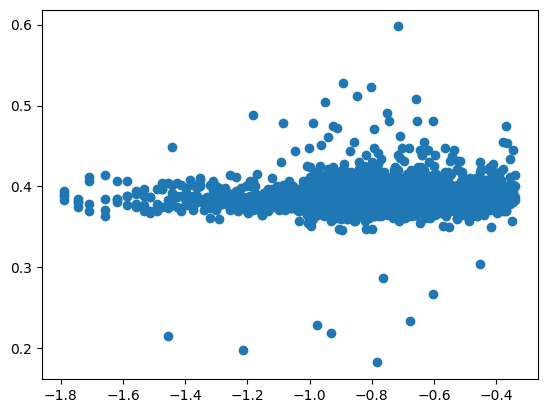

In [25]:
plt.scatter(params_Tru_LFI[:, 2], summaries_LFI[:, -4])
plt.show()
plt.close()

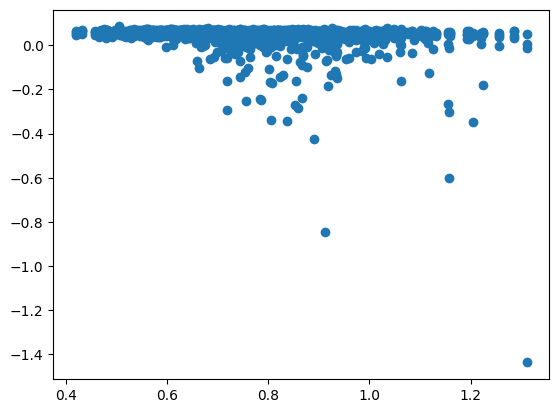

In [26]:
plt.scatter(params_Tru_LFI[:, 1], summaries_LFI[:, -3])
plt.show()
plt.close()

In [27]:
summaries_LFI[:, -2]

array([-0.003479  , -0.00091553,  0.00131226, ...,  0.01171875,
        0.00497437, -0.01031494], dtype=float32)

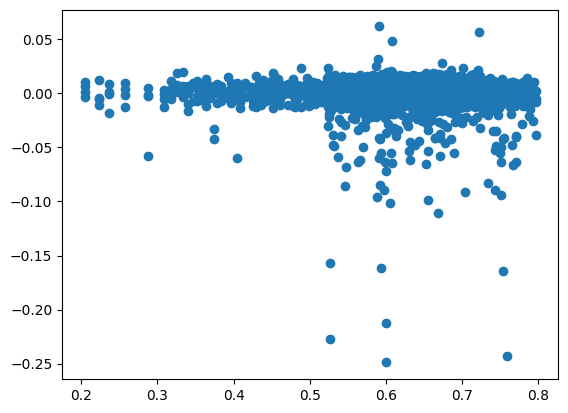

In [28]:
plt.scatter(params_Tru_test[:, 2], summaries_test[:, -2])
plt.show()
plt.close()

In [29]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [30]:
# make a dataloader for the predicted thetas and true thetas
#loader = NumpyLoader(x=np.concatenate([np.array(summs), summs_cls], axis=-1), theta=np.array(data['theta']))

In [31]:
for d in range(3):
    print(params_Tru_LFI[:, d].min() - 0.001, params_Tru_LFI[:, d].max() + 0.001)

0.13305349850654602 0.49777202105522156
0.41877009177207947 1.3120698461532592
-1.789894772529602 -0.33811600708961487


In [42]:
theta_fid = np.array([0.3, 0.8, -1.0])
np.argmin((params_Tru_LFI - theta_fid)**2)

4658

In [36]:
summaries_LFI.shape

(3088, 88)

In [34]:
def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

In [35]:
get_S8(params_Tru_LFI)[:, 1].max(), get_S8(params_Tru_LFI)[:, 1].min()

(0.9987983, 0.50127)

In [37]:
from ili.embedding import FCN


# CONVERT TO S8

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

loader = NumpyLoader(x=summaries_LFI,
                     theta=params_Tru_LFI_S8)

#n_hidden = [600, 300, 100, 4]
n_hidden = [100, 100, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "ReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble

nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=7),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    #ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [38]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 99

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 72 100 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 12173 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 401.9944591522217 seconds to train models.


 Neural network successfully converged after 122 epochs.

In [119]:
print("hi")

hi


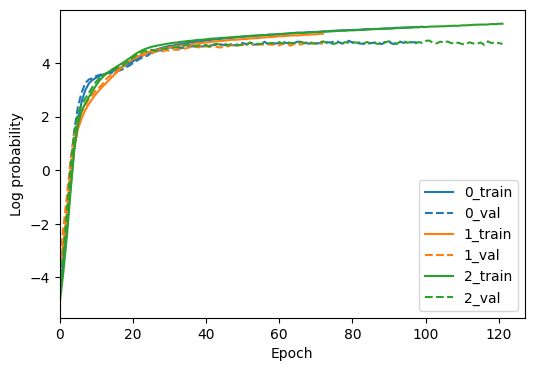

In [39]:
# FOR CNN + PK summaries

fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [53]:
# find somewhere close to fiducial

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

theta_fid = np.array([0.3, 0.8, -1.0])
target_index = np.argmin(np.mean(np.sqrt((params_Tru_LFI_S8 - theta_fid)**2)))

target_x = summaries_LFI[target_index]
target_theta = params_Tru_LFI_S8[target_index]

In [54]:
params_Tru_LFI_S8.shape, summaries_LFI.shape, target_index

((3088, 3), (3088, 88), 0)

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

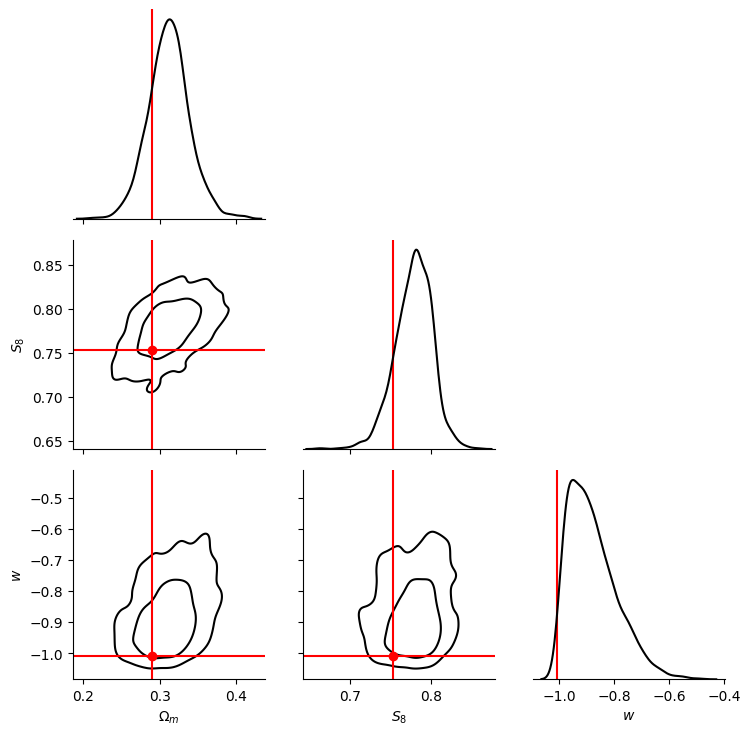

In [55]:

params = [r'$\Omega_m$', r'$S_8$', r'$w$']

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = target_x, theta_fid=target_theta
)
plt.show()

In [56]:
summaries_LFI[..., :-4].shape

(3088, 84)

In [57]:
# do Cls-only

from ili.embedding import FCN

# DO JUST CLS NOW
loader_cls = NumpyLoader(x=summaries_LFI[..., :-8],
                     theta=params_Tru_LFI_S8)

n_hidden = [100, 100, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "ReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=7),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    #ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner_cls = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
posterior_ensemble_cls, summaries_cls = runner_cls(loader=loader_cls)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 96

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 13397 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 76 134 epochs.

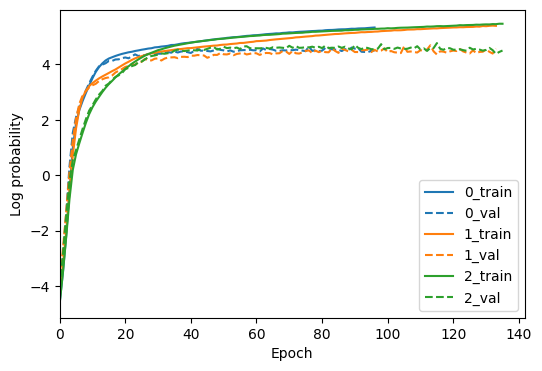

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries_cls):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [60]:
target_x.shape

(88,)

In [62]:
chains = posterior_ensemble.sample((100000,), x=torch.tensor(target_x).to(device))
chains_cls = posterior_ensemble_cls.sample((100000,), x=torch.tensor(target_x[:-8]).to(device))

Drawing 33963 posterior samples:   0%|          | 0/33963 [00:00<?, ?it/s]

Drawing 31980 posterior samples:   0%|          | 0/31980 [00:00<?, ?it/s]

Drawing 34057 posterior samples:   0%|          | 0/34057 [00:00<?, ?it/s]

Drawing 31490 posterior samples:   0%|          | 0/31490 [00:00<?, ?it/s]

Drawing 32878 posterior samples:   0%|          | 0/32878 [00:00<?, ?it/s]

Drawing 35632 posterior samples:   0%|          | 0/35632 [00:00<?, ?it/s]

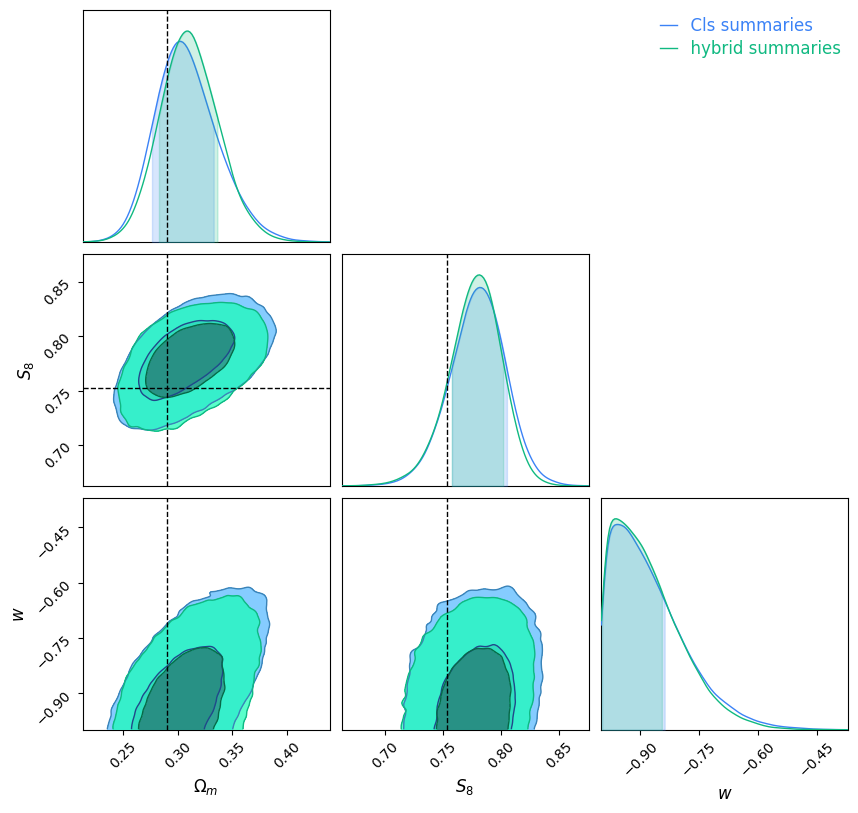

In [63]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

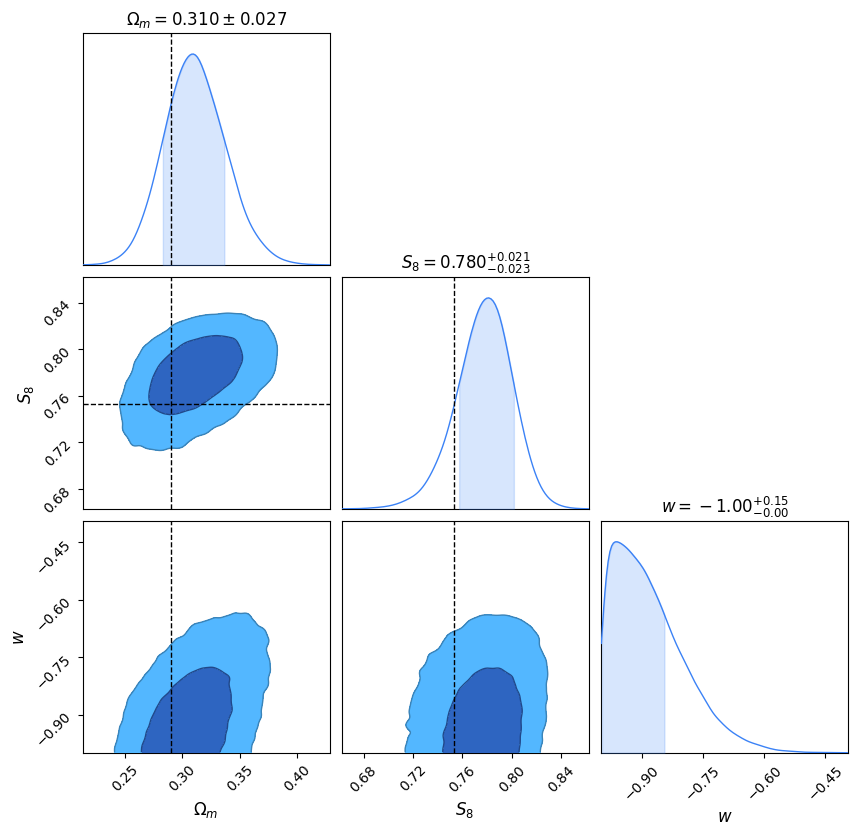

In [64]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
#df_cls = pd.DataFrame(get_S8(chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

#c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

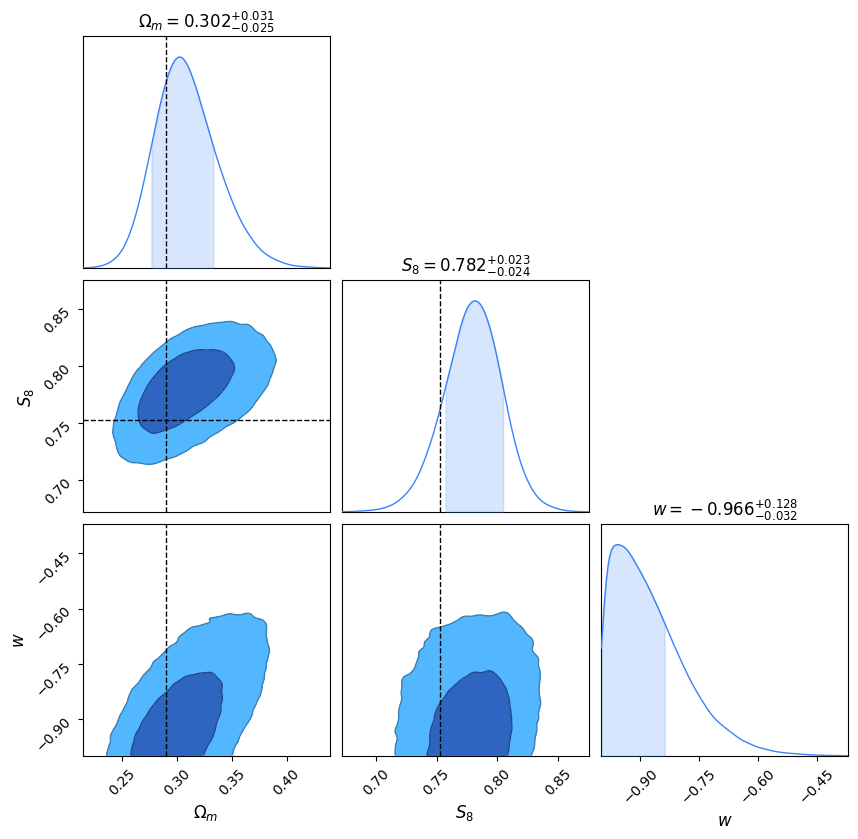

In [65]:
# LOOK AT CLS
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

#df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

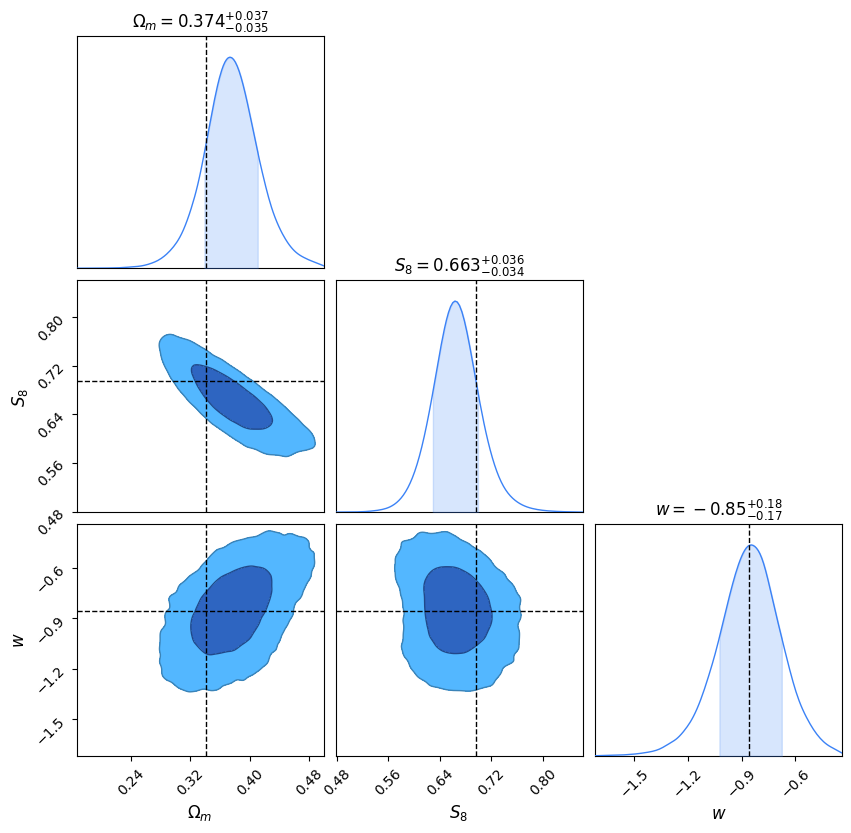

In [131]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame(chains.cpu().numpy(), columns=param_labels)
df_cls = pd.DataFrame(chains_cls.cpu().numpy(), columns=param_labels)


c = ChainConsumer()
#c.add_chain(Chain(samples = df_cls, name="Cls summaries"))

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: target_theta[0], param_labels[1]: target_theta[1], param_labels[2]:target_theta[2]}))


fig = c.plotter.plot()
plt.show()

In [66]:
np.savez("/home/makinen/repositories/des-hybrid/results_patch_A_B_19_12",
         summaries_LFI=summaries_LFI,
         params_LFI=params_Tru_LFI_S8,
         summaries_test=summaries_test,
         params_test=get_S8(params_Tru_test),
         chains_hybrid=chains.cpu().numpy(),
         chains_cls=chains_cls.cpu().numpy()
        )

In [68]:
# check coverage over TEST set

metric = PosteriorCoverage(
    num_samples=1000, sample_method='drect',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summaries_LFI, theta=get_S8(params_Tru_LFI)
)
plt.show()

  0%|          | 0/3088 [00:00<?, ?it/s]


NotImplementedError: 

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


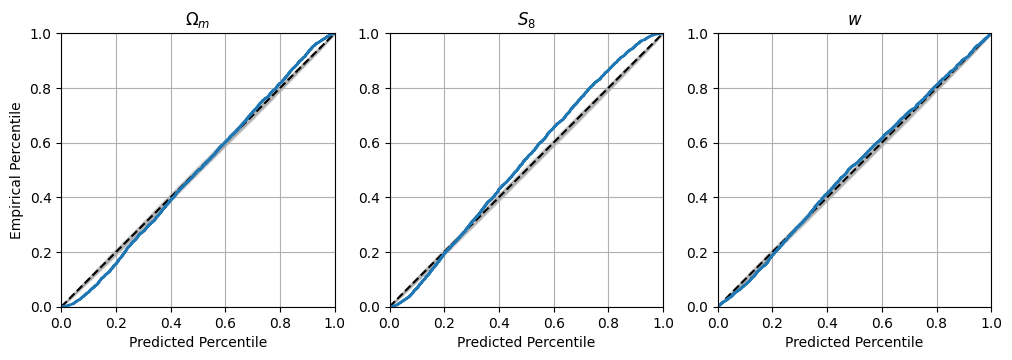

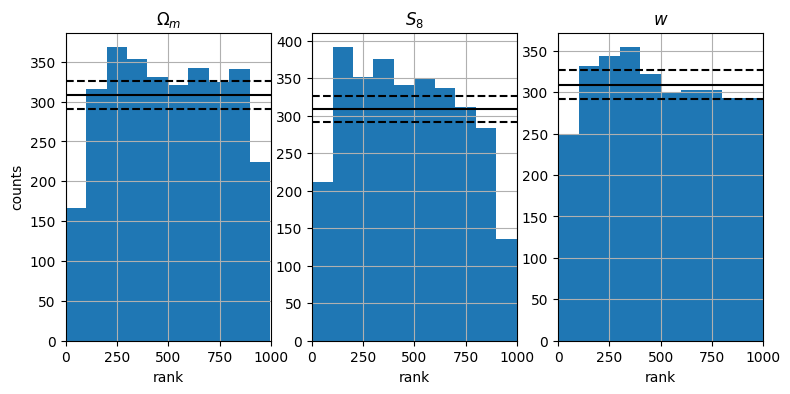

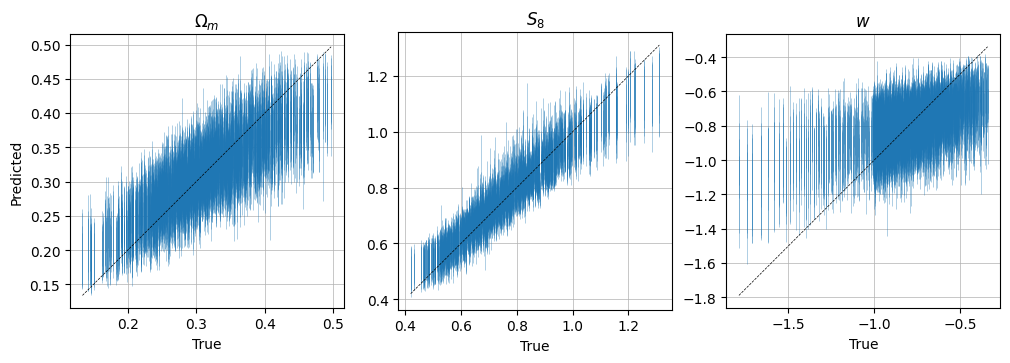

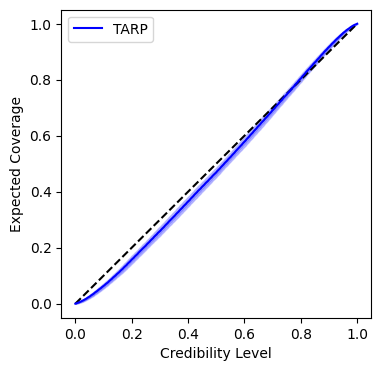

In [144]:
# check coverage

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summaries_test, theta=get_S8(params_Tru_test)
)
plt.show()

In [ ]:
# check parameter count

#sum(x.size for x in jax.tree_util.tree_leaves(wbest))